=== BƯỚC 1: TẢI THÔNG TIN VÀ DỮ LIỆU ===
Sử dụng thiết bị: cuda
Tìm thấy 76 classes.
Số lượng file test: 3870

=== BƯỚC 2: TẢI MÔ HÌNH ĐÃ HUẤN LUYỆN ===


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Tải thành công model từ: /kaggle/input/trafic-lo/pytorch/default/1/final_model.pth

=== BƯỚC 3: ĐÁNH GIÁ mAP TRÊN TẬP TEST ===


Evaluating: 100%|██████████| 968/968 [08:41<00:00,  1.86it/s]



--- KẾT QUẢ ĐÁNH GIÁ ---
==> Mean Average Precision (mAP) @ 0.5 IoU: 0.8173

Average Precision (AP) cho từng lớp:
- complementary--chevron-left: 0.9219
- complementary--chevron-right: 0.9384
- complementary--distance: 0.5719
- information--disabled-persons: 0.7539
- information--gas-station: 0.8926
- information--hospital: 0.9992
- information--motorway: 0.7256
- information--parking: 0.7675
- information--tram-bus-stop: 0.4272
- regulatory--axel-mass-limit: 0.9753
- regulatory--bicycles-only: 0.8491
- regulatory--go-straight: 0.8991
- regulatory--go-straight-or-turn-left: 0.7828
- regulatory--go-straight-or-turn-right: 0.8333
- regulatory--height-limit: 0.7449
- regulatory--keep-left: 0.7854
- regulatory--keep-right: 0.8289
- regulatory--maximum-speed-limit: 0.8900
- regulatory--no-bicycles: 0.7966
- regulatory--no-buses: 0.7576
- regulatory--no-entry: 0.6927
- regulatory--no-goods-vehicles: 0.9218
- regulatory--no-goods-vehicles-exceeding-limit: 0.8825
- regulatory--no-heavy-goods-v

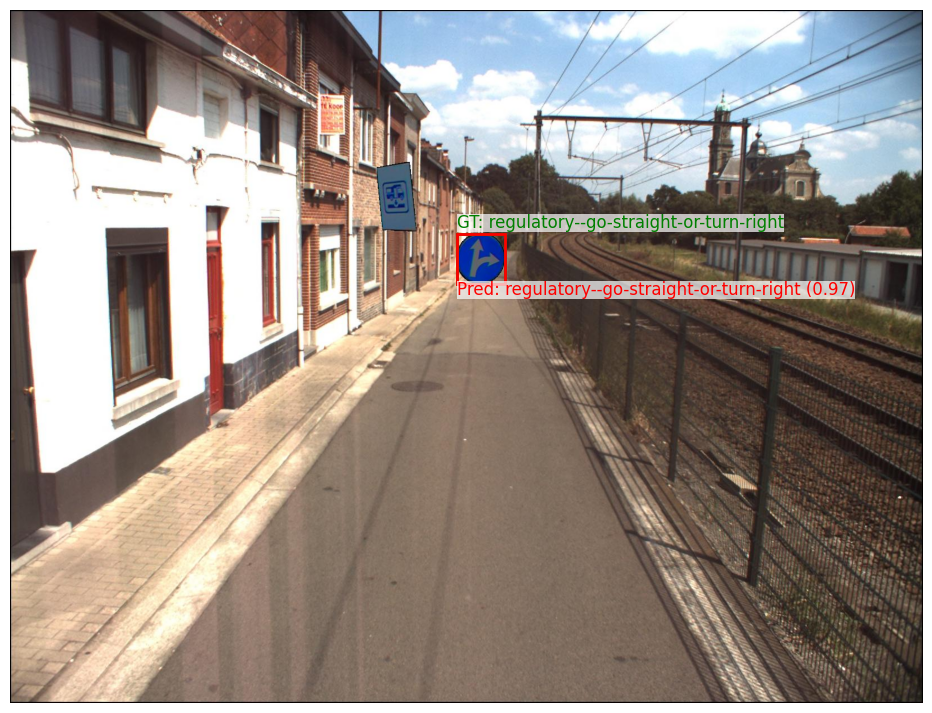

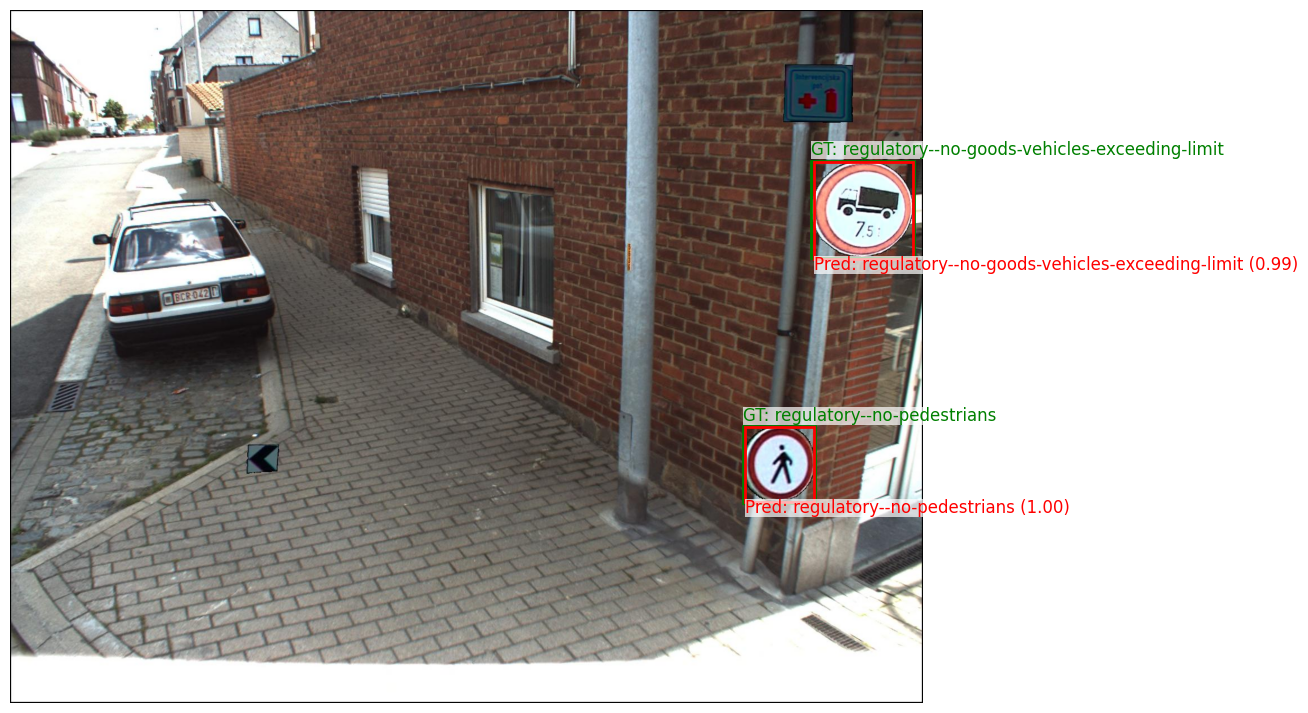

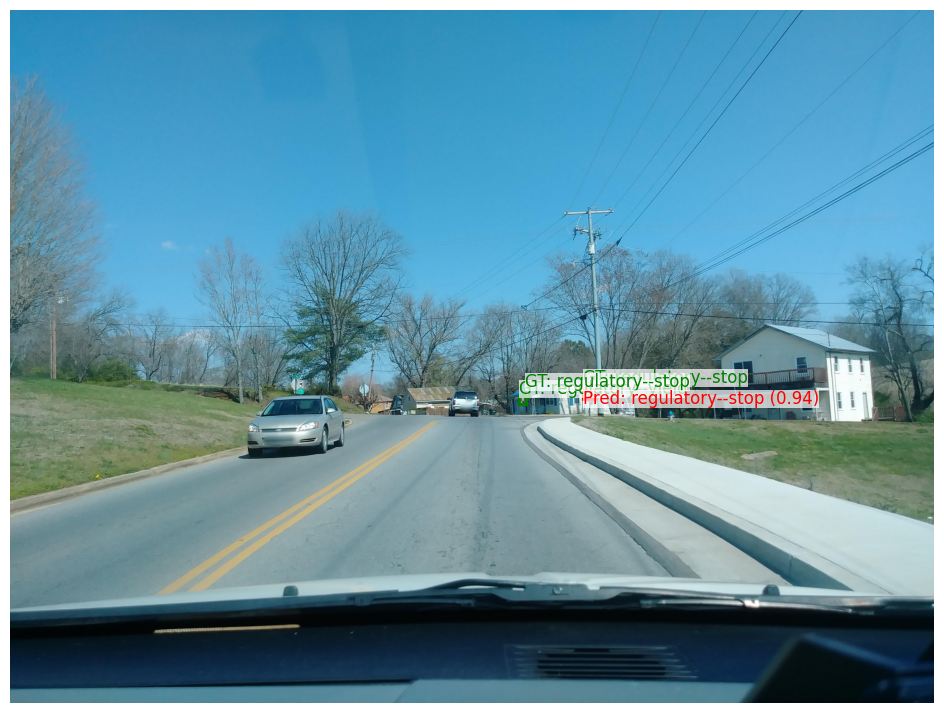

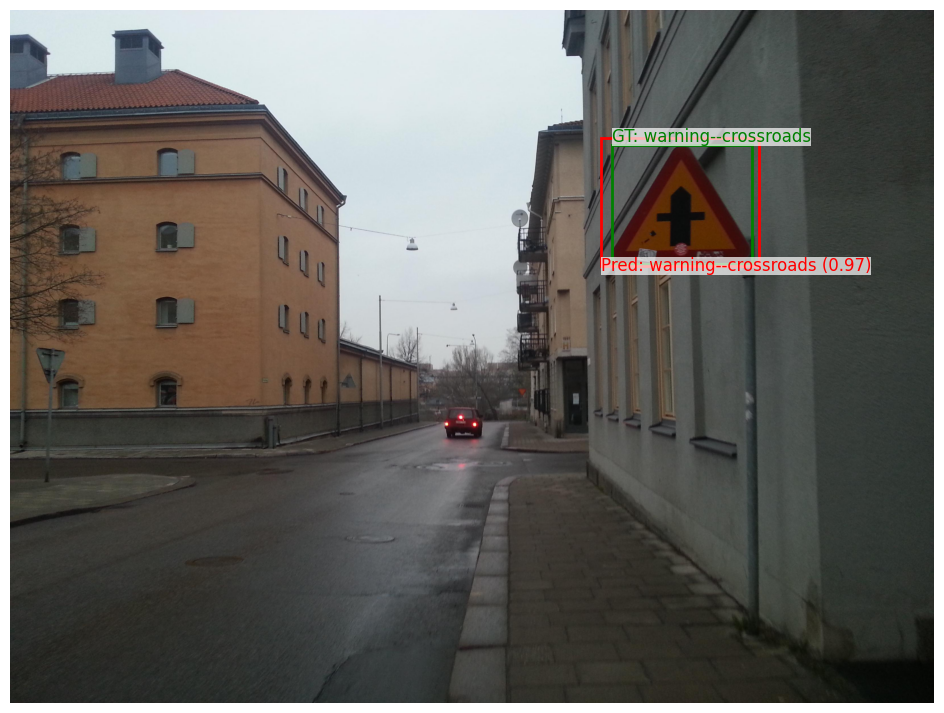

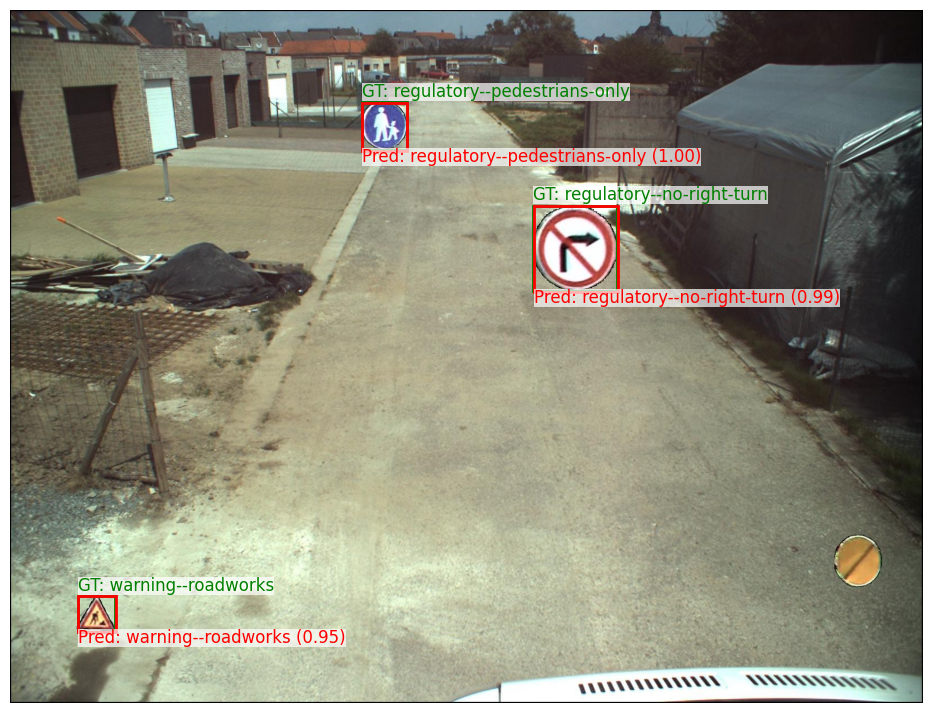

In [ ]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import xml.etree.ElementTree as ET
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from tqdm import tqdm
from collections import defaultdict


# --- ĐỊNH NGHĨA CÁC ĐƯỜNG DẪN ---
DATA_DIR = "/kaggle/input/traffic-sign-detection"
IMAGES_DIR = os.path.join(DATA_DIR, "images")
ANNOTATIONS_DIR = os.path.join(DATA_DIR, "xmls")



MODEL_DIR = "/kaggle/input/trafic-lo/pytorch/default/1" 
MODEL_PATH = os.path.join(MODEL_DIR, "final_model.pth") 

class ObjectDetectionDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, image_files, class_to_idx, transforms=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.image_files = image_files
        self.class_to_idx = class_to_idx
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        
        xml_name = os.path.splitext(img_name)[0] + '.xml'
        xml_path = os.path.join(self.annotations_dir, xml_name)

        boxes = []
        labels = []
        if os.path.exists(xml_path):
            tree = ET.parse(xml_path)
            root = tree.getroot()
            for obj in root.findall('object'):
                name = obj.find('name').text
                # Chỉ lấy các class đã được học trong lúc train
                if name in self.class_to_idx:
                    bbox = obj.find('bndbox')
                    xmin = float(bbox.find('xmin').text)
                    ymin = float(bbox.find('ymin').text)
                    xmax = float(bbox.find('xmax').text)
                    ymax = float(bbox.find('ymax').text)
                    if xmax > xmin and ymax > ymin:
                        boxes.append([xmin, ymin, xmax, ymax])
                        labels.append(self.class_to_idx[name])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        if boxes.shape[0] > 0:
            target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            target["area"] = torch.tensor(0.0)
        target["iscrowd"] = torch.zeros((len(boxes),), dtype=torch.int64)

        if self.transforms:
            image = self.transforms(image)

        return image, target

def get_class_mapping(annotations_dir):
    class_names = set()
    for xml_file in os.listdir(annotations_dir):
        if not xml_file.endswith('.xml'):
            continue
        tree = ET.parse(os.path.join(annotations_dir, xml_file))
        root = tree.getroot()
        for obj in root.findall('object'):
            class_names.add(obj.find('name').text)
    
    class_names = sorted(list(class_names))
    class_to_idx = {name: i + 1 for i, name in enumerate(class_names)}
    idx_to_class = {i: name for name, i in class_to_idx.items()}
    return class_to_idx, idx_to_class

def split_data(images_dir, test_size=0.2, val_size=0.1):
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))])
    train_files, temp_files = train_test_split(
        image_files, test_size=test_size + val_size, random_state=42
    )
    val_files, test_files = train_test_split(
        temp_files, test_size=test_size/(test_size + val_size), random_state=42
    )
    return train_files, val_files, test_files

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

def collate_fn(batch):
    return tuple(zip(*batch))

# ===================================================================
# HÀM TÍNH TOÁN mAP - THƯỚC ĐO CHÍNH XÁC
# ===================================================================

def calculate_ap(recall, precision):
    """Tính Average Precision (AP) từ đường precision-recall."""
    m_recall = np.concatenate(([0.], recall, [1.]))
    m_precision = np.concatenate(([0.], precision, [0.]))
    
    # Tính đường bao của precision
    for i in range(len(m_precision) - 2, -1, -1):
        m_precision[i] = max(m_precision[i], m_precision[i + 1])
        
    # Tính diện tích dưới đường cong bằng cách tìm các điểm thay đổi trên trục x (recall)
    i_list = []
    for i in range(1, len(m_recall)):
        if m_recall[i] != m_recall[i-1]:
            i_list.append(i)
    
    ap = 0.
    for i in i_list:
        ap += ((m_recall[i] - m_recall[i-1]) * m_precision[i])
    return ap

@torch.no_grad()
def evaluate_map(model, data_loader, device, iou_threshold=0.5):
    """
    Đánh giá mô hình trên một tập dữ liệu và tính Mean Average Precision (mAP).
    """
    model.eval()
    
    # Lưu trữ tất cả các dự đoán và ground truth
    all_predictions = []
    all_ground_truths = []

    for images, targets in tqdm(data_loader, desc="Evaluating"):
        images = list(img.to(device) for img in images)
        outputs = model(images)

        for i, output in enumerate(outputs):
            # output format: boxes, labels, scores
            # target format: boxes, labels
            all_predictions.append({
                'boxes': output['boxes'].cpu(),
                'scores': output['scores'].cpu(),
                'labels': output['labels'].cpu()
            })
            all_ground_truths.append({
                'boxes': targets[i]['boxes'].cpu(),
                'labels': targets[i]['labels'].cpu()
            })

    # Tính toán AP cho mỗi class
    aps_per_class = {}
    unique_classes = torch.cat([gt['labels'] for gt in all_ground_truths]).unique()
    
    for class_id in unique_classes:
        # Lấy tất cả các ground truth và predictions cho class hiện tại
        gt_boxes_cls = []
        pred_boxes_cls = []
        pred_scores_cls = []
        
        # Đếm tổng số ground truth cho class này trên toàn bộ dataset
        total_gt_cls = 0
        for i in range(len(all_ground_truths)):
            gt_labels = all_ground_truths[i]['labels']
            gt_mask = gt_labels == class_id
            gt_boxes_cls.append(all_ground_truths[i]['boxes'][gt_mask])
            total_gt_cls += gt_mask.sum().item()

            pred_labels = all_predictions[i]['labels']
            pred_mask = pred_labels == class_id
            pred_boxes_cls.extend(all_predictions[i]['boxes'][pred_mask])
            pred_scores_cls.extend(all_predictions[i]['scores'][pred_mask])

        if total_gt_cls == 0:
            continue
            
        # Sắp xếp các predictions theo confidence score giảm dần
        if len(pred_scores_cls) > 0:
            pred_scores_cls = torch.tensor(pred_scores_cls)
            pred_boxes_cls = torch.stack(pred_boxes_cls)
            sorted_indices = torch.argsort(pred_scores_cls, descending=True)
            pred_boxes_cls = pred_boxes_cls[sorted_indices]
        else:
            aps_per_class[int(class_id.item())] = 0.0
            continue

        # Tính True Positives (TP) và False Positives (FP)
        tp = torch.zeros(len(pred_boxes_cls))
        fp = torch.zeros(len(pred_boxes_cls))
        
        # Tạo một list để theo dõi các ground truth box đã được match
        gt_matched = [torch.zeros(len(boxes), dtype=torch.bool) for boxes in gt_boxes_cls]

        # Duyệt qua từng prediction đã sắp xếp
        for pred_idx, pred_box in enumerate(pred_boxes_cls):
            best_iou = -1
            best_gt_img_idx = -1
            best_gt_box_idx = -1
            
            # Tìm ground truth box phù hợp nhất (IoU cao nhất) trong tất cả các ảnh
            for img_idx in range(len(gt_boxes_cls)):
                gt_boxes = gt_boxes_cls[img_idx]
                if len(gt_boxes) == 0:
                    continue

                # Chỉ so sánh với các gt chưa được match
                unmatched_gt_mask = ~gt_matched[img_idx]
                if unmatched_gt_mask.sum() == 0:
                    continue

                # Tính IoU
                ious = torchvision.ops.box_iou(pred_box.unsqueeze(0), gt_boxes[unmatched_gt_mask])
                max_iou, max_idx = ious.max(1)
                
                if max_iou.item() > best_iou:
                    best_iou = max_iou.item()
                    best_gt_img_idx = img_idx
                    # Map max_idx trở lại index gốc trong gt_boxes
                    original_indices = torch.where(unmatched_gt_mask)[0]
                    best_gt_box_idx = original_indices[max_idx.item()]
            
            if best_iou >= iou_threshold:
                if not gt_matched[best_gt_img_idx][best_gt_box_idx]:
                    tp[pred_idx] = 1
                    gt_matched[best_gt_img_idx][best_gt_box_idx] = True # Đánh dấu là đã match
                else:
                    fp[pred_idx] = 1 # Match với GT đã được match trước đó -> FP
            else:
                fp[pred_idx] = 1
        
        # Tính precision và recall
        tp_cumsum = torch.cumsum(tp, dim=0)
        fp_cumsum = torch.cumsum(fp, dim=0)
        
        recalls = tp_cumsum / total_gt_cls
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
        
        # Tính AP
        ap = calculate_ap(recalls.numpy(), precisions.numpy())
        aps_per_class[int(class_id.item())] = ap
        
    mAP = np.mean(list(aps_per_class.values()))
    return mAP, aps_per_class

# ===================================================================
# BƯỚC 3: TRỰC QUAN HÓA KẾT QUẢ DỰ ĐOÁN
# ===================================================================

def visualize_predictions(model, dataset, device, idx_to_class, num_images=5, score_threshold=0.5):
    """Trực quan hóa dự đoán của mô hình trên một vài ảnh mẫu."""
    model.eval()
    
   
    colors = np.random.uniform(0, 255, size=(len(idx_to_class) + 1, 3))
    
    # Chọn ngẫu nhiên một vài ảnh từ dataset
    indices = np.random.choice(len(dataset), num_images, replace=False)
    
    for i in indices:
        image_tensor, target = dataset[i]
        
        # Chuyển ảnh tensor về định dạng OpenCV để vẽ
        # (C, H, W) -> (H, W, C) và scale về 0-255
        image_cv = image_tensor.permute(1, 2, 0).cpu().numpy()
        image_cv = (image_cv * 255).astype(np.uint8).copy()
        
        with torch.no_grad():
            prediction = model([image_tensor.to(device)])[0]

        fig, ax = plt.subplots(1, 1, figsize=(12, 9))
        ax.imshow(image_cv)
        
        # --- Vẽ Ground Truth (Màu xanh lá) ---
        for box, label in zip(target['boxes'], target['labels']):
            xmin, ymin, xmax, ymax = box
            class_name = idx_to_class[label.item()]
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                     linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin - 10, f'GT: {class_name}', color='green', fontsize=12,
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0))

        # --- Vẽ Predictions (Màu đỏ) ---
        for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
            if score > score_threshold:
                xmin, ymin, xmax, ymax = box.cpu().numpy()
                class_name = idx_to_class[label.item()]
                color = colors[label.item()] / 255.0
                
                rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                         linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(xmin, ymax + 20, f'Pred: {class_name} ({score:.2f})', color='red', fontsize=12,
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0))

        plt.axis('off')
        plt.show()

# ===================================================================
# BƯỚC 4: HÀM MAIN ĐỂ CHẠY TOÀN BỘ QUÁ TRÌNH
# ===================================================================

def main():
    print("=== BƯỚC 1: TẢI THÔNG TIN VÀ DỮ LIỆU ===")
    
    # Xác định thiết bị
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f"Sử dụng thiết bị: {device}")
    
    # Lấy mapping class
    class_to_idx, idx_to_class = get_class_mapping(ANNOTATIONS_DIR)
    num_classes = len(class_to_idx) + 1  # +1 cho background
    print(f"Tìm thấy {len(class_to_idx)} classes.")
    
    # Chia dữ liệu để lấy tập test (phải giống hệt lúc train)
    _, _, test_files = split_data(IMAGES_DIR)
    print(f"Số lượng file test: {len(test_files)}")

    # Tạo Test Dataset và DataLoader
    test_transforms = transforms.Compose([transforms.ToTensor()])
    test_dataset = ObjectDetectionDataset(
        IMAGES_DIR, ANNOTATIONS_DIR, test_files, class_to_idx, test_transforms
    )
    test_loader = DataLoader(
        test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn, num_workers=2
    )

    print("\n=== BƯỚC 2: TẢI MÔ HÌNH ĐÃ HUẤN LUYỆN ===")
    model = get_model(num_classes)
    
    # Tải trọng số đã lưu
    try:
        checkpoint = torch.load(MODEL_PATH, map_location=device)
        # Nếu lưu cả model.state_dict()
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        # Nếu chỉ lưu state_dict trực tiếp
        else:
            model.load_state_dict(checkpoint)
        print(f"Tải thành công model từ: {MODEL_PATH}")
    except Exception as e:
        print(f"Lỗi khi tải model: {e}")
        return
        
    model.to(device)

    print("\n=== BƯỚC 3: ĐÁNH GIÁ mAP TRÊN TẬP TEST ===")
    mAP, aps_per_class = evaluate_map(model, test_loader, device, iou_threshold=0.5)

    print("\n--- KẾT QUẢ ĐÁNH GIÁ ---")
    print(f"==> Mean Average Precision (mAP) @ 0.5 IoU: {mAP:.4f}")
    print("\nAverage Precision (AP) cho từng lớp:")
    for class_id, ap in aps_per_class.items():
        class_name = idx_to_class.get(class_id, f"Unknown ID: {class_id}")
        print(f"- {class_name}: {ap:.4f}")
    print("-------------------------")

    print("\n=== BƯỚC 4: TRỰC QUAN HÓA KẾT QUẢ DỰ ĐOÁN ===")
    visualize_predictions(model, test_dataset, device, idx_to_class, num_images=5, score_threshold=0.5)


if __name__ == "__main__":
    main()